In [1]:
import sys
sys.path.append('/home/gsatopolito/preLIMinary/')
sys.path.append('/home/gsatopolito/lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib

palette=['#346c79', '#c0a15d',  '#b06927', '#1e5732', '#5b957f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def linear(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

## Setting parameters for lim and lightcones

Only consider CO for now...

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    Z=2.45
    DZ=0.1
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3, 
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'BehrooziFile':SFR_file,'sig_SFR':0.3},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=True, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10000, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=100*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=1000, 
                      beam_FWHM=4*u.arcmin, 
                      tobs=10000*u.hr,
                      Omega_field=6.25*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 2.5
    model_params=dict(halo_lightcone_dir='/home/gsatopolito/JHU/Research/LC files/', output_root = "output/default", 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_LCO':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      supersample=1,
                      Nmu=1000)
    obs_params=dict(zmin = z_min, zmax = z_max,
                    RAObs_min=-1.25*u.deg,RAObs_max=1.25*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin, 
                    dnu=100*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK)
    obs_params.update(model_params)
    return obs_params

In [4]:
m = lim(lim_params('UM_sfr.dat', 20))
m_behroozi = lim(lim_params('sfr_release.dat', 20))

In [5]:
#setting lightcone parameters
CO = make_survey(LC_params(False, '', 20))

/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


## Testing the covariance calculation

We compute the theoretical covariance for each multipole within the lightcone module. E.g., for the monopole we have
\begin{equation}
C_{00}(k) = \frac{1}{2}\int_{-1}^{1} d\mu \frac{1}{N_{modes}(k,\mu)} \left(P(k,\mu) + P_n \right)^2.
\end{equation}

The only difference between the covariance matrix from lim and from the lightcone is the number of modes. The former computes then analytically while the latter uses the output from nbody-kit.

In [9]:
#power spectrum computed inside lightcone code
k_th, mu_th, PK_th=CO.Pk_2d_theo
P0_th=0.5*np.trapz(PK_th,mu_th,axis=0)

#covariance with the LIM power spectrum computed locally, but with Nmodes from lightcones 
#(making sure it matches the output from lightcones, should be identical!)
cov_integrand = (m.Pk+m.Pnoise)
cov = 0.5*np.trapz(cov_integrand**2,m.mu,axis=0)
cov_local=(interp1d(m.k.to(m.Mpch**-1),cov)(CO.k_Pk_poles[1:])/CO.Pk_2d.poles['modes'][1:])*(cov_integrand.unit**2)

Note: redshifts have been re-sorted (earliest first)


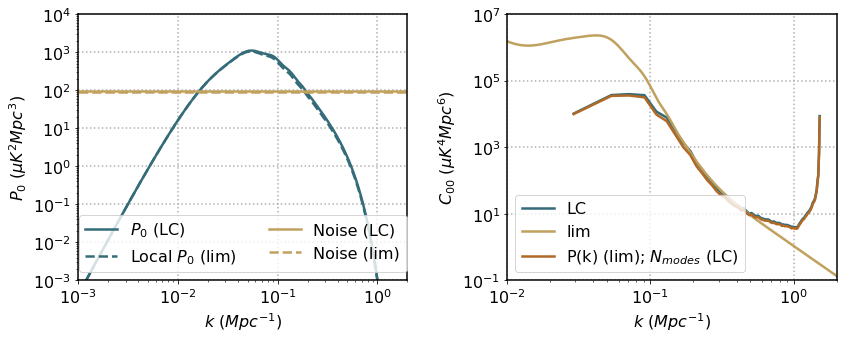

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.loglog(k_th.to(u.Mpc**-1), P0_th.to(CO.unit**2*u.Mpc**3), label='$P_0$ (LC)')
plt.loglog(m.k, m.Pk_0, '--C0', label='Local $P_0$ (lim)')
plt.loglog(m.k, np.ones((m.nk))*CO.sigmaN**2*CO.Vvox.to(u.Mpc**3), 'C1', label='Noise (LC)')
plt.loglog(m.k, m.Pnoise*(np.ones((m.nk))), '--C1', label='Noise (lim)')
plt.ylim(1e-3, 1e4)
plt.xlim(1e-3, 2)
plt.legend(ncol=2, loc='lower center')
plt.ylabel('$P_0$ ($\mu K^2 Mpc^3$)')
plt.xlabel('$k$ ($Mpc^{-1}$)')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.subplot(1,2,2)
plt.loglog(CO.k_Pk_poles[1:].to(u.Mpc**-1), CO.covmat_00.to(CO.unit**4*u.Mpc**6), label='LC')
plt.loglog(m.k, m.covmat_00, label='lim')
plt.loglog(CO.k_Pk_poles[1:].to(u.Mpc**-1),cov_local.to(CO.unit**4*u.Mpc**6), label='P(k) (lim); $N_{modes}$ (LC)')
plt.xlabel('$k$ ($Mpc^{-1}$)')
plt.ylabel('$C_{00}$ ($\mu K^4 Mpc^6$)')
plt.ylim(1e-1,1e7)
plt.xlim(1e-2, 2)
plt.grid(linestyle='dotted', linewidth=1.5)
plt.legend(loc='lower left')

plt.tight_layout()

## Testing VIDs

First with no instrumental noise, changing the scatter in the mass/luminosity relation

In [6]:
CO = make_survey(LC_params(False, '', 0))

sigs_scatter=[0.3, 0.65, 1]

Bi_scatter=np.zeros((len(sigs_scatter), m.Nbin_hist))
for i in range(len(sigs_scatter)):
    m.update(Tsys_NEFD=0*u.K, sigma_scatter=sigs_scatter[i])
    Bi_scatter[i]=m.Bi

/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits
Note: redshifts have been re-sorted (earliest first)


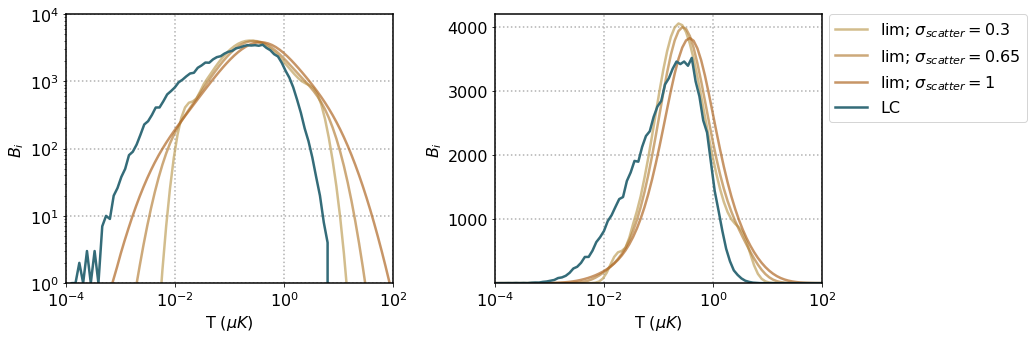

In [7]:
cmap=linear(palette[1],palette[2])
colors = cmap(np.linspace(0,1,3))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i in range(len(sigs_scatter)):
    plt.loglog(m.Ti, Bi_scatter[i], label=r'lim; $\sigma_{scatter} = $'+str(sigs_scatter[i]), color=colors[i], alpha=0.7)
plt.loglog(CO.Ti, CO.Bi_VID, label='LC')
plt.ylim(1, 1e4)
plt.xlim(1e-4, 1e2)
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.subplot(1,2,2)
for i in range(len(sigs_scatter)):
    plt.plot(m.Ti, Bi_scatter[i], label=r'lim; $\sigma_{scatter} = $'+str(sigs_scatter[i]), color=colors[i], alpha=0.7)
plt.plot(CO.Ti, CO.Bi_VID, label='LC')
plt.ylim(1, 4200)
plt.xlim(1e-4, 1e2)
plt.xscale('log')
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.tight_layout()

plt.legend(loc=(1.02,0.6))

In [60]:
print(sum(CO.Bi_VID), sum(m.Bi), CO.Nchan*CO.Npix)

77420 76007.04809309731 77440


### Adding instrument noise to VID prediction

The probability of observing a pixel with temperature T is given by the convolution between signal and instrumental noise probabilities
\begin{equation}
\mathcal{P}_{tot}(T) = (\mathcal{P}_{signal} * \mathcal{P}_{N})(T),
\end{equation}
where we assume a Gaussian pdf for the instrument noise.

The total VIDs are then recomputed with the total pdf using
\begin{equation}
B_i = N_{vox}\int_{T_{min, i}} ^{{T_{max, i}}} \mathcal{P}_{tot}(T) dT
\end{equation}

In [89]:
m.update(Tsys_NEFD=20*u.K, sigma_scatter=0.3)

#signal pdf
PTlist=np.concatenate((np.zeros((m.nT)), m.PT))
Tlist=np.concatenate((-m.T[::-1], m.T))
PTsignal=interp1d(Tlist, PTlist, fill_value='extrapolate')

#noise pdf
sigN2=m.Pnoise/m.Vvox
TT=np.linspace(-1e2, 1e2, m.nT)*(m.T.unit)
norm = (2.*np.pi*sigN2)**0.5
PTnoise = interp1d(TT, (np.exp(-0.5*TT**2/sigN2)/norm).to((TT**-1).unit), fill_value='extrapolate')

In [90]:
#compute convolution integral manually due to log space binning
Tpos=np.logspace(-4, 3, 1000)
Tconv=np.concatenate((-Tpos[::-1], Tpos))

PTconv=np.zeros((len(Tconv)))
for i in range(len(Tconv)):
    PTconv[i]=integrate.simpson(PTsignal(Tconv)*PTnoise(Tconv[i]-Tconv), Tconv)
PTtot=interp1d(Tconv, PTconv)

#compute new VIDs
Bitot=np.zeros((len(m.Ti)))
for i in range(len(m.Tedge_i)-1):
    Tbin=np.logspace(np.log10(m.Tedge_i.value[i]), np.log10(m.Tedge_i.value[i+1]), 100)
    Bitot[i]=m.Nvox*integrate.simpson(PTtot(Tbin), Tbin)

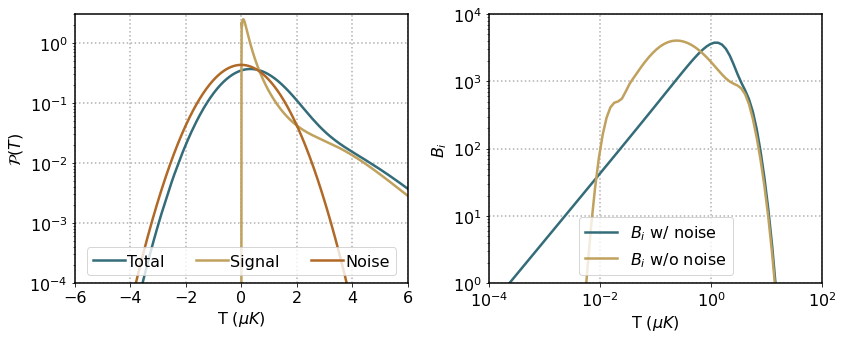

In [112]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(Ttot, PTtot(Ttot), label=r'Total')
plt.plot(Ttot, PTsignal(Ttot), label=r'Signal')
plt.plot(Ttot, PTnoise(Ttot), label=r'Noise')
plt.xlim(-6, 6)
#plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3, 2)
plt.ylim(1e-4, 3)
plt.legend(loc='lower center', ncol=3, handletextpad=0.1)
plt.grid(linestyle='dotted', linewidth=1.5)
plt.xlabel('T ($\mu K$)')
plt.ylabel(r'$\mathcal{P} (T)$')

plt.subplot(1,2,2)
plt.plot(m.Ti, Bitot, label='$B_i$ w/ noise')
plt.plot(m.Ti, m.Bi, label='$B_i$ w/o noise')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4, 1e2)
plt.ylim(1, 1e4)
plt.grid(linestyle='dotted', linewidth=1.5)
plt.legend()
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')

plt.tight_layout()

### lim & LC with noise

In [9]:
Tsys=[10,20,40]

Blim_Tsys=np.zeros((len(Tsys), m.Nbin_hist))
for j in range(len(Tsys)):
    m.update(Tsys_NEFD=Tsys[j]*u.K)

    #signal pdf
    PTlist=np.concatenate((np.zeros((m.nT)), m.PT))
    Tlist=np.concatenate((-m.T[::-1], m.T))
    PTsignal=interp1d(Tlist, PTlist, fill_value='extrapolate')

    #noise pdf
    sigN2=m.Pnoise/m.Vvox
    TT=np.linspace(-1e2, 1e2, m.nT)*(m.T.unit)
    norm = (2.*np.pi*sigN2)**0.5
    PTnoise = interp1d(TT, (np.exp(-0.5*TT**2/sigN2)/norm).to((TT**-1).unit), fill_value='extrapolate')
    
    #compute convolution integral manually due to log space binning
    Tpos=np.logspace(-4, 3, 1000)
    Tconv=np.concatenate((-Tpos[::-1], Tpos))

    PTconv=np.zeros((len(Tconv)))
    for i in range(len(Tconv)):
        PTconv[i]=integrate.simpson(PTsignal(Tconv)*PTnoise(Tconv[i]-Tconv), Tconv)
    PTtot=interp1d(Tconv, PTconv)

    #compute new VIDs
    for i in range(len(m.Tedge_i)-1):
        Tbin=np.logspace(np.log10(m.Tedge_i.value[i]), np.log10(m.Tedge_i.value[i+1]), 100)
        Blim_Tsys[j,i]=m.Nvox*integrate.simpson(PTtot(Tbin), Tbin)

In [10]:
BLC_Tsys=np.zeros((len(Tsys),CO.Nbin_hist))
for i in range(len(Tsys)):
    CO = make_survey(LC_params(False, '', Tsys[i]))
    BLC_Tsys[i]=CO.Bi_VID

/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


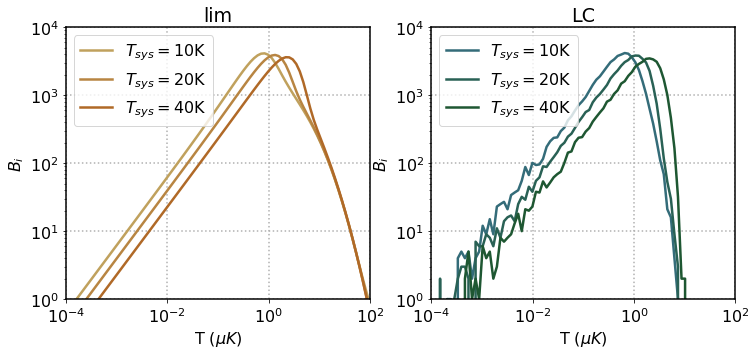

In [11]:
cmap1=linear(palette[1],palette[2])
colors1 = cmap1(np.linspace(0,1,3))

cmap2=linear(palette[0],palette[3])
colors2 = cmap2(np.linspace(0,1,3))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i in range(len(Tsys)):
    plt.loglog(m.Ti, Blim_Tsys[i], color=colors1[i], label='$T_{sys} = $'+str(Tsys[i])+'K')
plt.xlim(1e-4, 1e2)
plt.ylim(1, 1e4)
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.title('lim')
plt.legend()

plt.subplot(1,2,2)
for i in range(len(Tsys)):
    plt.loglog(CO.Ti, BLC_Tsys[i], color=colors2[i], label='$T_{sys} = $'+str(Tsys[i])+'K')
plt.xlim(1e-4, 1e2)
plt.ylim(1, 1e4)
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.legend()
plt.title('LC')
plt.show()

### Pk and VIDs with different SFRs

Here we input different SFR tables in the lightcones in order to compare the effect in the power spectra and VIDs. Note that we are comparing two external SFR tables (i.e. not the direct output from the lightcone).

This next cell take a while to run...

In [8]:
CO_behrooziSFR = make_survey(LC_params(True, 'Behroozi_SFR', 0))
CO_UMSFR = make_survey(LC_params(True, 'UniverseMachine_SFR', 0))

/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/lightcone.py:185: RuntimeWarning: divide by zero encountered in log10
  SFR = 10**(np.random.normal(np.log10(SFR), self.sig_extSFR))


/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


In [9]:
m.update(Tsys_NEFD=0*u.K)

/home/gsatopolito/miniconda3/envs/nbodykit-env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/gsatopolito/miniconda3/envs/nbodykit-env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


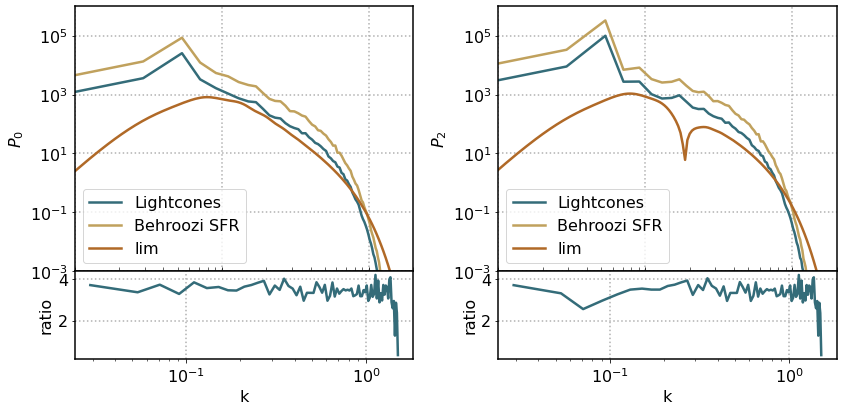

In [15]:
f, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1], 'hspace':0.0}, figsize=(12,6))

ax[0,0].loglog(CO_UMSFR.k_Pk_poles, CO_UMSFR.Pk_0, label='Lightcones')
ax[0,0].loglog(CO_behrooziSFR.k_Pk_poles, CO_behrooziSFR.Pk_0, label='Behroozi SFR')
ax[0,0].loglog(m.k.to(CO.Mpch**-1), m.Pk_0.to(CO.unit**2*CO.Mpch**3), label='lim')
ax[0,0].set_ylim(1e-3, 1e6)
ax[0,0].set_xlim(1e-2, 2)
ax[0,0].set_xticklabels([])
ax[0,0].tick_params(axis="x",direction="in", which='both', length=4)
ax[0,0].set_ylabel('$P_0$')
ax[0,0].legend()
ax[0,0].grid(linestyle='dotted', linewidth=1.5)

ax[1,0].plot(CO_UMSFR.k_Pk_poles[:-73], CO_behrooziSFR.Pk_0[:-73]/CO_UMSFR.Pk_0[:-73])
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('k')
ax[1,0].set_ylabel('ratio')
ax[1,0].grid(linestyle='dotted', linewidth=1.5)

ax[0,1].loglog(CO_UMSFR.k_Pk_poles, abs(CO_UMSFR.Pk_2), label='Lightcones')
ax[0,1].loglog(CO_behrooziSFR.k_Pk_poles, abs(CO_behrooziSFR.Pk_2), label='Behroozi SFR')
ax[0,1].loglog(m.k.to(CO.Mpch**-1), abs(m.Pk_2.to(CO.unit**2*CO.Mpch**3)), label='lim')
ax[0,1].set_ylim(1e-3, 1e6)
ax[0,1].set_xlim(1e-2, 2)
ax[0,1].set_xticklabels([])
ax[0,1].tick_params(axis="x",direction="in", which='both', length=4)
ax[0,1].set_ylabel('$P_2$')
ax[0,1].legend()
ax[0,1].grid(linestyle='dotted', linewidth=1.5)

ax[1,1].plot(CO_UMSFR.k_Pk_poles[:-73], abs(CO_behrooziSFR.Pk_2[:-73])/abs(CO_UMSFR.Pk_2[:-73]))
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('k')
ax[1,1].set_ylabel('ratio')
ax[1,1].grid(linestyle='dotted', linewidth=1.5)
f.tight_layout()
#plt.savefig('SFR_Pk_comparison.png', dpi=300)

Note: redshifts have been re-sorted (earliest first)


/home/gsatopolito/miniconda3/envs/nbodykit-env/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)


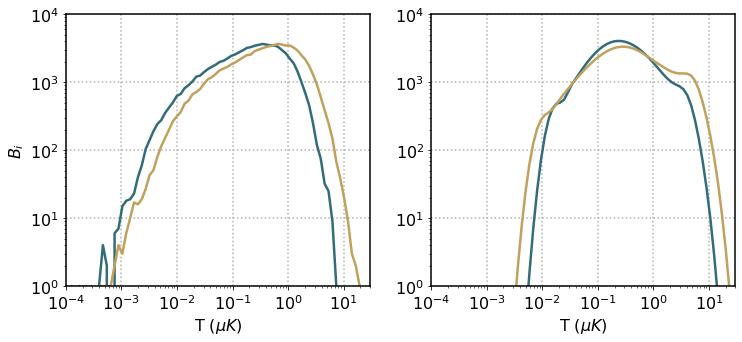

In [24]:
m.update(Tsys_NEFD=0*u.K)
m_behroozi.update(Tsys_NEFD=0*u.K)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.loglog(CO_UMSFR.Ti, CO_UMSFR.Bi_VID)
plt.loglog(CO_behrooziSFR.Ti, CO_behrooziSFR.Bi_VID)
#plt.loglog(CO.Ti, CO.Bi_VID, 'C0--')
plt.ylim(1, 1e4)
plt.xlim(1e-4, 30)
plt.xlabel('T ($\mu K$)')
plt.ylabel('$B_i$')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.subplot(1,2,2)
plt.loglog(m.Ti, m.Bi)
plt.loglog(m_behroozi.Ti, m_behroozi.Bi)
plt.ylim(1, 1e4)
plt.xlim(1e-4, 30)
plt.xlabel('T ($\mu K$)')
plt.grid(linestyle='dotted', linewidth=1.5)

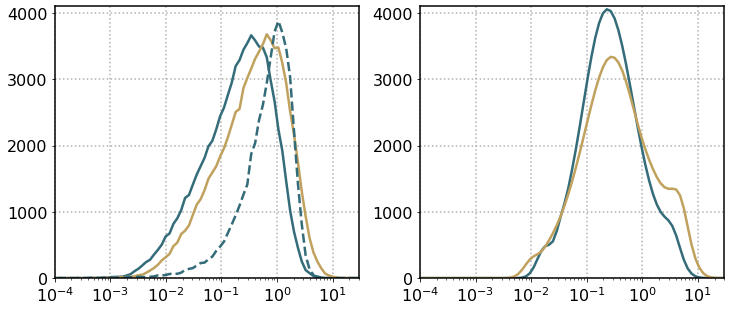

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(CO_UMSFR.Ti, CO_UMSFR.Bi_VID)
plt.plot(CO_behrooziSFR.Ti.value, CO_behrooziSFR.Bi_VID)
plt.plot(CO.Ti, CO.Bi_VID, '--C0')
plt.ylim(0, 4100)
plt.xlim(1e-4, 30)
plt.xscale('log')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.subplot(1,2,2)
plt.plot(m.Ti, m.Bi)
plt.plot(m_behroozi.Ti, m_behroozi.Bi)
plt.xscale('log')
plt.ylim(0, 4100)
plt.xlim(1e-4, 30)
plt.grid(linestyle='dotted', linewidth=1.5)

### Testing VIDs

In [5]:
m = lim(lim_params('CO','TonyLi', 2.45, 0.1, 'UM_sfr.dat'))

beam=[2,4,6]
Nvox=np.zeros((len(beam)))
Blim_beam=np.zeros((3, 101))
for i in range(len(beam)):
    m.update(beam_FWHM=beam[i]*u.arcmin)
    Blim_beam[i]=m.Bi
    Nvox[i]=m.Nvox
    
BLC_beam=np.zeros((len(beam),100))
for i in range(len(beam)):
    CO = make_survey(dict(halo_lightcone_dir='/home/gsatopolito/JHU/Research/LC files/',lines=dict(CO=True),
                          models=dict(CO=dict(model_name='CO_Li16',model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_LCO':0.3})),do_external_SFR = False, external_SFR = '',
                          zmin = z_min, zmax = z_max,RAObs_min=-1.25*u.deg,RAObs_max=1.25*u.deg, supersample=1,Tsys=0*u.K, Nmu=1000, Nfeeds=1000, tobs=10000*u.hr,
                          output_root = "output/default", nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),dnu=100*u.MHz,beam_FWHM=beam[i]*u.arcmin, linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK))
    BLC_beam[i]=CO.Bi_VID

Note: redshifts have been re-sorted (earliest first)
/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits
/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


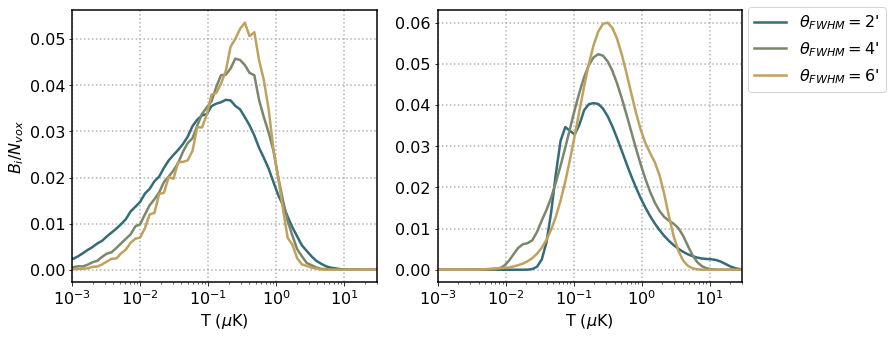

In [18]:


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for i in range(len(beam)):
    plt.plot(CO.Ti, BLC_beam[i]/Nvox[i], color=colors[i], label=r'$\theta_{FWHM}=$'+str(beam[i])+'\'')
plt.xscale('log')
plt.xlim(1e-3, 30)
plt.xlabel('T ($\mu$K)')
plt.ylabel('$B_i/N_{vox}$')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.subplot(1,2,2)
for i in range(len(beam)):
    plt.plot(m.Ti, Blim_beam[i]/Nvox[i], color=colors[i], label=r'$\theta_{FWHM}=$'+str(beam[i])+'\'')
plt.xscale('log')
plt.xlim(1e-3, 30)
plt.legend(loc=(1.02,0.7))
plt.xlabel('T ($\mu$K)')
plt.grid(linestyle='dotted', linewidth=1.5)

plt.show()

### Luminosity function comparison

In [27]:
LCOcat=CO.L_line_halo['CO'].value
LF_LC=np.histogram(LCOcat, bins=m.L.value)[0]

In [28]:
np.trapz(LF_LC/np.diff(m.L.value)/(CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3), x=m.L.value[:-1])

<Quantity 1.17427175 1 / Mpc3>

In [29]:
len(LCOcat)/(CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3)

<Quantity 1.18744647 1 / Mpc3>

In [34]:
m = lim(lim_params('CO','TonyLi', 2.45, 0.1, 'UM_sfr.dat'))
m.update(Tsys_NEFD=0*u.K, sigma_scatter=1)

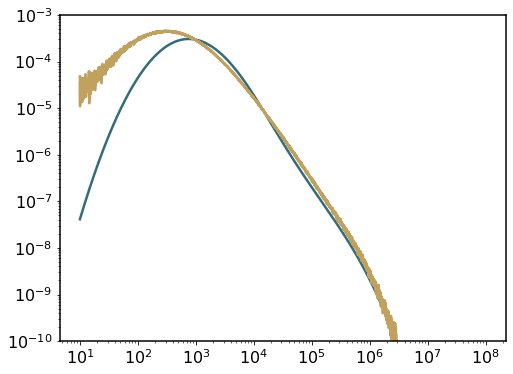

In [35]:
plt.loglog(m.L.value, m.dndL/0.064126)
plt.loglog(m.L.value[:-1101], LF_LC[:-1100]/np.diff(m.L.value[:-1100])/(CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3))
plt.ylim(1e-10, 1e-3)
plt.yscale('log')

In [30]:
np.trapz(m.dndL[:-1], x=m.L[:-1])

<Quantity 0.07614699 1 / Mpc3>

In [32]:
m.nbar/1.1874465

<Quantity 0.06412656 1 / Mpc3>

In [167]:
m.update(nM=50)

In [34]:
np.min(Mcat)

<Quantity 1.0000034e+10 solMass>

In [32]:
Mcat=(CO.halo_catalog['M_HALO']*u.Msun)
MF_LC, Mbins=np.histogram(np.log10(Mcat.value), bins=np.log10(m.M.value))

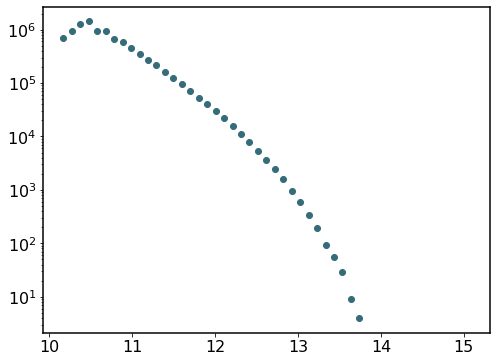

In [169]:
plt.plot(Mbins[:-1], MF_LC, 'o')
plt.yscale('log')

In [189]:
np.trapz(MF_LC/np.diff(Mbins)/(CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3), x=Mbins[:-1])

<Quantity 1.08420681 1 / Mpc3>

In [ ]:
m = lim(lim_params('CO','TonyLi', 2.45, 0.1, 'UM_sfr.dat'))
m.update()

(10.0, 15.0)

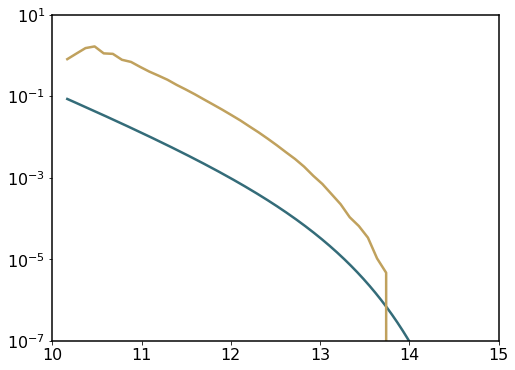

In [192]:
plt.plot(np.log10(m.M.value),m.M*m.dndM)
plt.plot(Mbins[:-1], MF_LC/np.diff(Mbins)/(CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3))
plt.yscale('log')
plt.ylim(1e-7,1e1)
plt.xlim(10, 15)